### A net for sample detection

In [1]:
# imports

# keras
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.optimizers import Adam, SGD, Adagrad
from keras.callbacks import ModelCheckpoint
from keras.layers import Input, concatenate, Convolution2D, MaxPooling2D, UpSampling2D, Reshape, core, Dropout
import keras.backend as K

# weighted cross-entropy
from kerasFunctions import my_binary_crossentropy

Using TensorFlow backend.
C:\Users\myersadmin\AppData\Roaming\Python\Python35\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# building the network

inputs = Input((None, None,1))
conv1 = Conv2D(8, (5, 5), strides=(1,1), activation='relu', padding='same', data_format='channels_last')(inputs)
# conv1 = Dropout(0.2)(conv1)
# conv1 = Conv2D(32, (3,3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
#
conv2 = Conv2D(16, (5, 5), activation='relu', padding='same')(pool1)
# conv2 = Dropout(0.2)(conv2)
# conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
# #
conv3 = Conv2D(32, (5, 5), activation='relu', padding='same')(pool2)
# conv3 = Dropout(0.2)(conv3)
# conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)

up1 = UpSampling2D(size=(2, 2))(conv3)
conv4 = Conv2D(16, (5, 5), activation='relu', padding='same')(up1)
# conv4 = Dropout(0.2)(conv4)
# conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)
# #
up2 = UpSampling2D(size=(2, 2))(conv4)
conv5 = Conv2D(8, (5, 5), activation='relu', padding='same')(up2)
# conv5 = Dropout(0.2)(conv5)
# conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv5)
#
# here nb_classes used to be just the number 2
conv6 = Conv2D(1, (1, 1), activation='sigmoid',padding='same')(conv5)
# conv6 = core.Reshape((2, 100*100))(conv6)
# conv6 = core.Permute((2,1))(conv6)
############

model = Model(inputs=inputs, outputs=conv6)
#     model.compile(optimizer=Adam(lr=0.0001), loss=my_categorical_crossentropy((1,100)), metrics=['accuracy'])
model.compile(optimizer=Adam(lr=0.001), loss=my_binary_crossentropy((1,1)), metrics=['accuracy'])
#     model.compile(optimizer=Adam(lr=0.0000001), loss='binary_crossentropy', metrics=['accuracy'])
#     model.compile(optimizer=Adam(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])



In [3]:
def normalize(img):
    if (not (type(img)is np.ndarray)):
        print("this is not an array")
        return
    elif (img.ndim !=2):
        return
        print("not a 2d image")
    else:
        minVal = img.min()
        
        return (img-minVal)/(img.max()-minVal)

In [4]:
def normalizeWithLimits(dataset, upLim=99.9, loLim=0.01):
    upLim = np.percentile(dataset, 99.9)
    loLim = np.percentile(dataset, 0.01)
    res = np.maximum(dataset - loLim, 0)
    res = np.minimum(res, upLim)
    res = res/(upLim-loLim+0.0000001)
    return res
    

In [5]:
import numpy as np

dataset = np.random.rand(100,100,10)
upLim = np.percentile(dataset, 99.9)
loLim = np.percentile(dataset, 0.01)
res = np.maximum(dataset - loLim, 0)
res = np.minimum(res, upLim.astype("float64"))
res = res/(upLim-loLim)


In [6]:
import tifffile
eg = tifffile.imread("../resources/SampleDetectionRealTimeDataset/1/149_fused-3.tif")
eg.shape

(64, 64)

In [6]:
import os
import tifffile

yes = []
no = []

# dataDir = "../resources/SampleDetectionRealTimeDataset/"
dataDir = "../resources/SampleDetectionDataset/"
timeRange=10

if (os.path.isdir(dataDir)):
    yesPath = dataDir+"/sample/"
    noPath = dataDir+"/bg/"
   
    for fname in os.listdir(yesPath):
#         print(fname + "\n")
        if (fname.endswith("tif")):
            arr = tifffile.imread(yesPath+fname)
            yes.append(arr)
            
    for fname in os.listdir(noPath):
#         print(fname + "\n")
        if (fname.endswith("tif")):
            arr = tifffile.imread(noPath+fname)
            no.append(arr)
else:
    print("no such dir")

In [8]:
pos = np.array(yes)
neg = np.array(no)

# eg = tifffile.imread("../resources/sampleDetectionDataset/bg/P0.tif")
# eg.shape

In [9]:
import numpy as np
from augment import generate_augmented_set

pos = np.array(yes)
neg = np.array(no)

posSize = pos.shape[0]
negSize = neg.shape[0]

dataset = normalizeWithLimits(np.concatenate((pos,neg)).astype("float64"))

pos_aug = generate_augmented_set(dataset[0:posSize])
neg_aug = generate_augmented_set(dataset[posSize:])
np.random.shuffle(pos_aug)
np.random.shuffle(neg_aug)

x = np.concatenate((pos_aug,neg_aug))
y = np.concatenate((np.ones(pos_aug.shape), np.zeros(neg_aug.shape)))

X = x[...,np.newaxis]
Y = y[..., np.newaxis]

Augmented set generation...
Initial set size: 93x100x100
Final set size: 744x100x100
Augmented set generation...
Initial set size: 89x100x100
Final set size: 712x100x100


In [10]:
pos.shape

(93, 100, 100)

In [11]:
upLim = np.percentile(np.concatenate((pos,neg)), 99.9)
loLim = np.percentile(np.concatenate((pos,neg)), 0.01)

In [12]:
r = np.array([1,2,3,4])
r.astype("float64")

array([1., 2., 3., 4.])

(<matplotlib.image.AxesImage at 0x4063dd30>,
 <matplotlib.colorbar.Colorbar at 0x40656e48>)

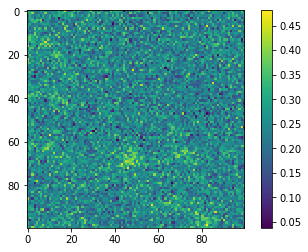

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(neg_aug[1]), plt.colorbar()

In [15]:
model.fit(X, Y, epochs=10, batch_size=20)

Epoch 1/10
1456/1456 [==============================] - 6s - loss: 0.5535 - acc: 0.6633     
Epoch 2/10
1456/1456 [==============================] - 1s - loss: 0.1552 - acc: 0.9735     
Epoch 3/10
1456/1456 [==============================] - 1s - loss: 0.0935 - acc: 0.9748     
Epoch 4/10
1456/1456 [==============================] - 1s - loss: 0.0697 - acc: 0.9827     
Epoch 5/10
1456/1456 [==============================] - 1s - loss: 0.0587 - acc: 0.9852     
Epoch 6/10
1456/1456 [==============================] - ETA: 0s - loss: 0.0532 - acc: 0.986 - 1s - loss: 0.0537 - acc: 0.9868     
Epoch 7/10
1456/1456 [==============================] - 1s - loss: 0.0532 - acc: 0.9870     
Epoch 8/10
1456/1456 [==============================] - 1s - loss: 0.0471 - acc: 0.9888     
Epoch 9/10
1456/1456 [==============================] - 1s - loss: 0.0466 - acc: 0.9883     
Epoch 10/10
1456/1456 [==============================] - 1s - loss: 0.0429 - acc: 0.9892     


In [16]:
fullStack = tifffile.imread("../resources/SampleDetectionRealTimeDataset/149_fused.tif")
fullStackNorm = np.zeros(fullStack.shape)

for i in range(fullStack.shape[0]):
    fullStackNorm[i,:,:] = normalizeWithLimits(fullStack[i,:,:], 99.9)

In [18]:
fullStackNorm[i][np.newaxis,...,np.newaxis].shape

(1, 3868, 1976, 1)

In [19]:
h = np.zeros(fullStackNorm.shape)
for i in range(fullStack.shape[0]):
    h[i,0:-4,0:-4] = model.predict(fullStackNorm[i,0:-4, 0:-4][np.newaxis,...,np.newaxis])[0,:,:,0]
    
# tifffile.imsave("../resources/SampleDetectionRealTimeDataset/stackSegmented.tif", h)

In [20]:
p = model.predict(fullStackNorm[30,0:-2, 0:-2][np.newaxis,...,np.newaxis])[0,:,:,0]

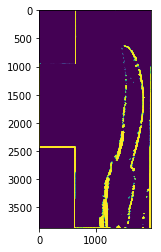

In [23]:
plt.imshow(h[20,:,:])

In [24]:
# saving
from __future__ import print_function, unicode_literals, absolute_import, division

import tensorflow as tf
import os
import warnings
import tempfile, shutil
from keras import backend as K
from tensorflow.python.framework import graph_util
from tensorflow.python.framework import graph_io

def export_SavedModel(model, outpath, format='zip'):
    # assert not os.path.exists(dirname)

    def export_to_dir(dirname):
        if len(model.input_layers) > 1 or len(model.output_layers) > 1:
            warnings.warn('not tested with multiple input or output layers')
        builder = tf.saved_model.builder.SavedModelBuilder(dirname)
        signature = tf.saved_model.signature_def_utils.predict_signature_def(
            inputs  = {"input":  model.input},
            outputs = {"output": model.output}
        )
        signature_def_map = { tf.saved_model.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY : signature }
        builder.add_meta_graph_and_variables(K.get_session(),
                                             [tf.saved_model.tag_constants.SERVING],
                                             signature_def_map=signature_def_map)
        builder.save()

    if format=='dir':
        export_to_dir(outpath)
    else:
        with tempfile.TemporaryDirectory() as tmpdir:
            tmpsubdir = os.path.join(tmpdir,'model')
            export_to_dir(tmpsubdir)
            shutil.make_archive(outpath, format, tmpsubdir)

In [26]:
export_SavedModel(model, outpath="../resources/model_detection_enc_dec", format="dir")

AssertionError: Export directory already exists. Please specify a different export directory: ../resources/model_detection_enc_dec

In [27]:
# saving model
json_string = model.to_json()

In [28]:
import json
with open('model_detection_enc_dec_json', 'w') as outfile:
    json.dump(json_string, outfile)

In [29]:
# saving weights
model.save_weights('model_detection_enc_dec_json_weights.h5')

In [123]:
v = [np.var(fullStack[i,1000:1400,708:1230]) for i in range(fullStackNorm.shape[0])]
s = [np.sum(h[i,1000:1400,708:1230]) for i in range(h.shape[0])]

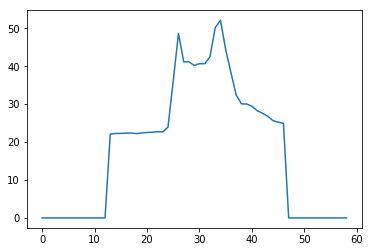

In [124]:
plt.plot(v)

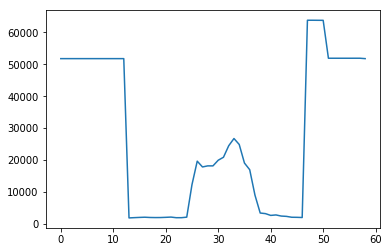

In [125]:
plt.plot(s)

(<matplotlib.image.AxesImage at 0x6c48dbe0>,
 <matplotlib.colorbar.Colorbar at 0x6c67e400>)

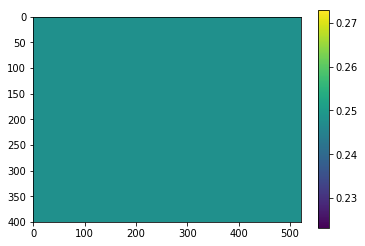

In [132]:
plt.imshow(h[2,1000:1400,708:1230]), plt.colorbar()

In [114]:
fullStack.shape

(59, 3868, 1976)

In [101]:
tifffile.imsave("../resources/SampleDetectionRealTimeDataset/stackSegmented.tif", (255*h).astype('uint8'))

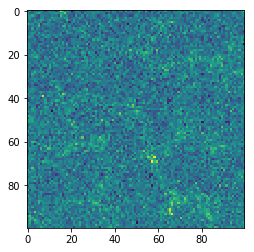

In [48]:
plt.imshow(tneg)

(<matplotlib.image.AxesImage at 0x21d01908>,
 <matplotlib.colorbar.Colorbar at 0x23010780>)

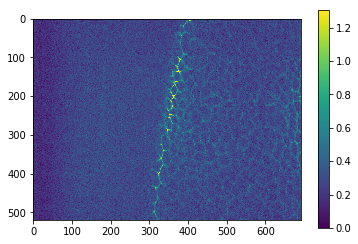

In [195]:
from qualityMeasure import *
testTile = readTile(pathToDataset="../resources/img/", tileNum=9, channelNum=3)
testFrame = normalizeWithLimits(testTile[18,:,:])
plt.imshow(testFrame), plt.colorbar()

In [196]:
pr = model.predict(testFrame[np.newaxis,:,:-1,np.newaxis])

(<matplotlib.image.AxesImage at 0x2308e0b8>,
 <matplotlib.colorbar.Colorbar at 0x230db9e8>)

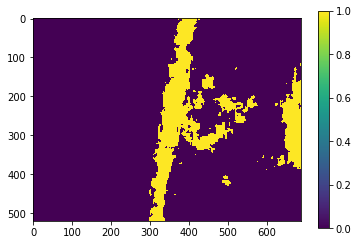

In [197]:
plt.imshow(pr[0,:,:,0]>0.99), plt.colorbar()

In [182]:
profIntNet = []

processedStack = np.zeros(testTile.shape)
testTile = testTile = readTile(pathToDataset="../resources/img/", tileNum=9, channelNum=3)
for i in range(testTile.shape[0]):
    processedStack[i,:,:] = 255*model.predict(normalizeWithLimits((testTile[i,:,:]))[np.newaxis, :,:,np.newaxis])[0,:,:,0]
profIntNet.append(getIntensityProfile(processedStack))

In [162]:
profIntNet = np.array(profIntNet)

TypeError: 'AxesSubplot' object does not support indexing

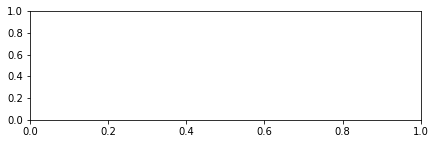

In [163]:
plotProfile(profIntNet)

In [183]:
tifffile.imsave("processedStack.tif", processedStack.astype("uint8"))

In [130]:
h = model.predict((testTile[22,:,:])[np.newaxis, :,:,np.newaxis])[0,:,:,0]

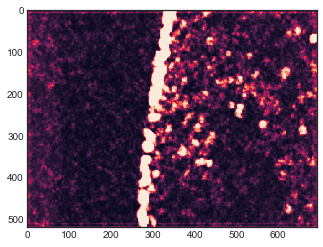

In [131]:
plt.imshow(processedStack[22,:,:])

In [138]:
profVarNet = getVarianceProfile(processedStack)
profIntNet = getIntensityProfile(processedStack>0.95*255)

In [139]:
np.var(processedStack[40,:,:])

828.74795507846352

In [140]:
import seaborn as sns
sns.set_style("white")

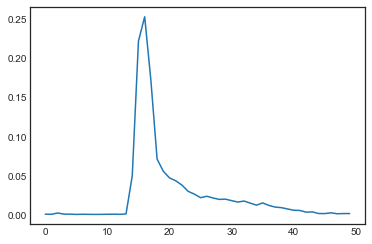

In [141]:
plt.plot(profIntNet)

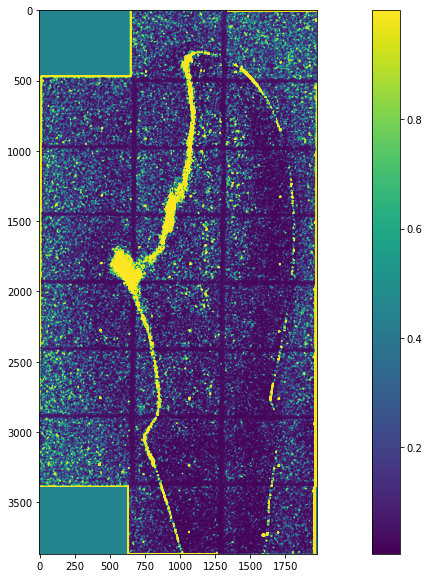

In [141]:
from pylab import rcParams
rcParams["figure.figsize"] =20,10
plt.imshow(pr[0,:,:,0]), plt.colorbar()
image.imsave("mask.png", pr[0,:,:,0])

In [26]:
y.shape

(18, 100, 100)

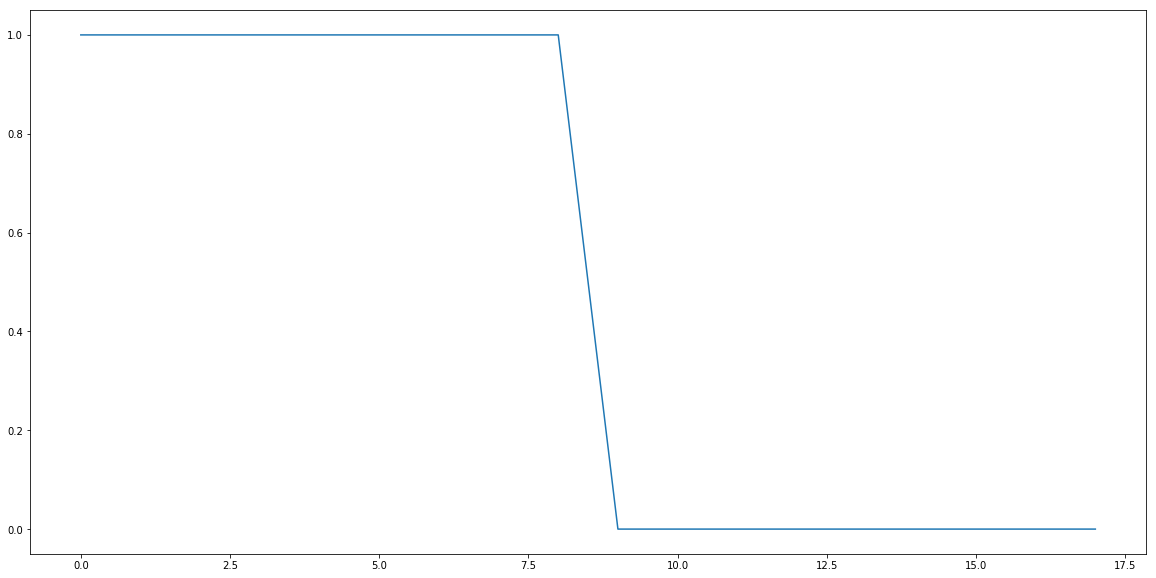

In [27]:
plt.plot(y[:,0,0])

In [28]:
from matplotlib import image

In [35]:
# full = image.imread("WT_25deg_160330_timelapseRaworiginal_140.png")[:,:,0]
full = tif2array("slice.tif")

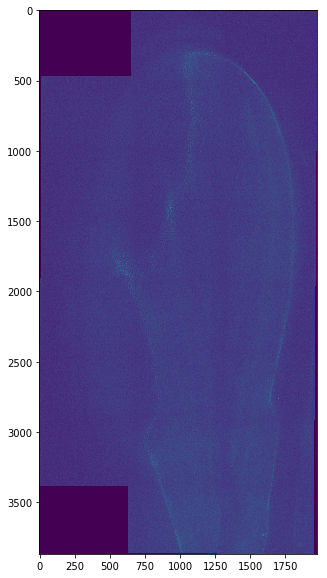

In [37]:
plt.imshow(full)

In [31]:
mask

NameError: name 'mask' is not defined

In [32]:
import gputools

[Errno 2] No such file or directory: 'C:\\cygwin64\\home\\myersadmin/.gputools'
<pyopencl.Device 'TITAN X (Pascal)' on 'NVIDIA CUDA' at 0x4da98ba0>


In [33]:
blur = gputools.blur(pr[0,:,:,0],width=20)
blur = gputools.blur(blur,width=20)
blur = gputools.blur(blur,width=20)

NameError: name 'pr' is not defined

In [ ]:
plt.imshow(blur>1.1*1e8), plt.colorbar()

In [50]:
full.shape

(3868, 1976)